<a href="https://colab.research.google.com/github/herdward/datasets/blob/master/visualization_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#![alt text](https://www.beyerblinderbelle.com/storage/website_logo.svg "Beyer Blinder Belle logo")
---
##**VISUALIZATIONS**##
---
#Guidance#

Welcome to this Jupyter Notebook for visualizations

Jupyter notebooks, (like this one) contain cells, each of which have a bit of python code (by default DCT "hides" the actual code, just to make the UI cleaner). 

---
Notes:
- Ideally, your data would have been cleaned via the <u>text cleanup</u> notebook first

- Optionally, your data may have been processed through the NLP notebook to match responses with user-defined tags.
  - <i> There are no guarantees that this notebook will be stable for data that isn't from the output of the <b>language processing</b> notebook </i>


To use this notebook:


- Click the play button to the left of each cell to execute that code. 

- Start at the top cell, and then work downwards one at a time. You'll see an indicator spin when a cell is processing.

- When a cell finishes running, it will show a green checkmark. 

- As you run each cell, the script will prompt you for any required inputs, guiding you through the workflow. Be sure to complete any UI selections before moving to the next cell.
- If there is an error, read the error message for guidance and fix inputs and re-run the cell by clicking the red play button.
- After making an UI selection, if there is no output within a second or two within the same cell, move on to the next one and press the play button on that cell to run it.

Additional Info
- Google Colab comes with some built in tools that may be of use:
  - This icon might appear to the bottom left of a dataframe. 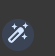. 
  - Click that icon to expand the dataframe.
  - Once you have expanded the dataframe, there are these tools available: 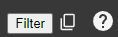. You can filter by a word in multiple columns, and you can also copy the current displayed output as a CSV, JSON, or Markdown file.

#Import necessary libraries






In [ ]:
#@title Import necessary libraries 
import pandas as pd
from pandas.core.frame import DataFrame
from google.colab import files
import re
import io
import sys
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install squarify --quiet
import squarify
!pip install ipywidgets --quiet
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px

class TreeMapPlot():
  def create(tagsToResponses:dict):
    """
    Parameter tagsToResponses: a dictionary mapping tags to the responses with that tag
    Returns a pandas dataframe object
    """
    treeMapProcessDf = pd.DataFrame({'tag':[],
                      'response':[], 
                      'size':[]})
    
    for tag in tagsToResponses:
      for response in tagsToResponses[tag]:
        treeMapLstToAppend = [tag, response, 1]
        #convert to series so can be appended to Df
        row = pd.Series(treeMapLstToAppend, index = ['tag', 'response', 'size'])
        treeMapProcessDf = treeMapProcessDf.append(row, ignore_index = True)
    for tag in tagsToResponses:
      pass # maybe try to get the scores to be appended as well
    return treeMapProcessDf

#Upload files


In [ ]:
#@title Upload your dataset as a csv file
#@markdown For most of the visualizations, it is extremely ideal if the data you upload
#@markdown is the csv output from the language processing notebook.
#@markdown <br>
#@markdown This cell will display an "upload" button. Please select a csv file that you wish to clean and spellcheck.


#@markdown <br> <b><u>If you get an error</b></u> that says something along the lines of google.colab._files is not defined,
#@markdown <br> or 'Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable' <br>
#@markdown Try:
#@markdown - Enabling cookies for colab.research.google.com in your browser
#@markdown - Disabling any adblockers or content blockers
#@markdown - Not using incognito or private browsing mode
#@markdown - A different browser
#@markdown 
uploaded = files.upload()
filename = list(uploaded.keys())[0]
dfInit = pd.read_csv(io.BytesIO(uploaded[filename]))
dfInit = dfInit.fillna('')
dfInit

#Demographics visualization
- only relevant if your data has demographics in column(s)
- choose your columns that have demographic data

In [ ]:
#@title Choose demographics filters 
# This could be an interactive interface
# For now, create a histogram of the demographics of the respondents
demVisStyle = {'description_width':'initial'}
demVisDf = dfInit.copy()
demVisSelectMultiple = widgets.SelectMultiple(style = demVisStyle, 
                                              options = demVisDf.columns,
                                              rows = len(demVisDf.columns),
                                              layout = widgets.Layout(width = 'auto'),
                                              description = 'Choose demographics filters ')
display(demVisSelectMultiple)

In [ ]:
#@title Show bar charts of the demographic data you have selected.

for demographicIdentifier in demVisSelectMultiple.value:
  dfInit[demographicIdentifier].value_counts().plot.bar(title = demographicIdentifier, cmap = 'Pastel2')
  plt.figure()
plt.show()


#Sortable table visualization
Sort by a tag (ascending or descending), and filter the responses by a word/phrase

In [ ]:
#@title Interactive interface that shows sortable table
#@markdown To use this, you must use a csv that was outputted from the language processing notebook.

def getTags(dataframe):
  #assumes that the dataframe being operated on is one that was processed 
  #by the language processing notebook
  #OTHERWISE, would have to prompt the user and ask which columns are the tags
  return list(dataframe.columns)[1:]

drillDownDf = dfInit.copy()
drillDownOutput = widgets.Output()
style = {'description-width':'initial'}
sortByTagDrop = widgets.Dropdown(options = getTags(drillDownDf),
                                 description = 'Choose tag to sort by', 
                                 style = style)

sortAscendingDrop = widgets.Dropdown(options = ['Ascending', 'Descending'], 
                                     value = 'Ascending', description = 'Sort by')

sortAscendingLabel = widgets.Label('Sort by')

resetAllFilters = widgets.ToggleButton(description = 'Reset all filters', value = False)
filterByWordInput = widgets.Text(description = 'Filter by word')
plotButton = widgets.ToggleButton(description = 'plot (does nothing)', value = False)
plotButton.layout.visibility = 'hidden' # comment this out if developing this feature
commonFilterDf = drillDownDf.copy()
def common_filtering(tag:str, ascend:str, resetTruthValue:bool, filterWord:str):
  ascending = True if ascend.lower() == 'ascending' else False
  if resetTruthValue:
    commonFilterDf = drillDownDf.copy() #reverts back to original
    resetAllFilters.value = False
  else:
      commonFilterDf = drillDownDf.sort_values(by = tag, ascending = ascending)
      #commonFilterDf = drillDownDf[drillDownDf[drop.value].str.contains(filterByWordInput.value).any()].sort_values(by = tag, ascending = ascending)
      if filterWord != '':
        commonFilterDf = commonFilterDf[commonFilterDf[drillDownDf.columns[0]].str.contains(filterWord)]

  with drillDownOutput:
    clear_output(wait = True)
    display(commonFilterDf)

def sortByTagDropEventHandler(change):
  common_filtering(change.new, sortAscendingDrop.value, resetAllFilters.value, '')
def sortAscendingDropEventHandler(change):
  common_filtering(sortByTagDrop.value, change.new, resetAllFilters.value, '')
def resetAllFiltersEventHandler(change):
  common_filtering(sortByTagDrop.value, sortAscendingDrop.value, change.new, '')
def filterByWordInputEventHandler(change):
  common_filtering(sortByTagDrop.value, sortAscendingDrop.value, resetAllFilters.value, change.new)
def plotButtonEventHandler(change):
  pass

drillDownHBox = widgets.HBox(children = [sortByTagDrop, filterByWordInput])

sortByTagDrop.observe(sortByTagDropEventHandler, names = 'value')
sortAscendingDrop.observe(sortAscendingDropEventHandler, names = 'value')
resetAllFilters.observe(resetAllFiltersEventHandler, names = 'value')
filterByWordInput.observe(filterByWordInputEventHandler, names = 'value')

#initial updating of the dataframe, so that the default values are represented in the output
# default meaning the first tag and ascending. Before this segment of code was written,
# the dataframe was either hidden/not sorted until the user changed the selections
# but that is not wanted behavior if the user turned out to want
#whatever was set to default 
commonFilterDf = drillDownDf.sort_values(by = sortByTagDrop.value, ascending = sortAscendingDrop.value)
with drillDownOutput:
  display(commonFilterDf)
# end initial updating of the dataframe
display(resetAllFilters, sortByTagDrop, sortAscendingDrop, filterByWordInput, plotButton, drillDownOutput)

In [ ]:
#@title Get the output of the sortable table as shown above as a csv file
#@markdown WIP
pass

#Treemap chart where multiple tags could be true

In [ ]:
#@title Set a threshold which determines whether a tag is applicable for a certain row.
#@markdown Is it only relevant if the tag is 50% or more applicable?
#@markdown 30%? This is where you decide
#@markdown <br> <br> <em>You can also key in the value by clicking on '0.00%' to the right of the slider</em>
treeMapMultDf = dfInit.copy()
#make a bounded int text and bounded int slider
treeMapMultTagFloatSlider = widgets.FloatSlider(value = 60, min = 0, max = 100, step = 0.1, readout_format = ".2f")
treeMapMultTagFloatSlider.description = 'Numbers are percentages'
treeMapMultTagFloatSlider.style = {'description_width':'initial'}
treeMapMultTagFloatSlider


In [ ]:
#@title Select which columns are your "tags"
#@markdown - Therefore, it is best if you are only trying to get a TreeMap from data that has been processed from the language processing notebook.
treeMapMultStyle = {'description_width':'initial'}
treeMapMultSelect = widgets.SelectMultiple(options = treeMapMultDf.columns, 
                                           style = treeMapMultStyle, layout = widgets.Layout(width = 'auto'),
                                           description = 'Select which columns are your tags')
display(treeMapMultSelect)

In [ ]:
#@title Calculate which responses meet the threshold for the tags
#create a dictionary where each tag
# has a list of responses where it is present
treeMapMultTags =treeMapMultSelect.value 
treeMapThreshold = treeMapMultTagFloatSlider.value

def meetThreshold(num) ->bool:
  """
  Returns a boolean based on whether or not a number meets the threshold
  defined by the user above.
  """
  return num >= treeMapThreshold/100

treeMapMultDict = {}
#loop through the series
for colindex, tag in enumerate(treeMapMultTags):
  for rowindex, responseScore in enumerate(treeMapMultDf[tag]):
    if meetThreshold(responseScore):
      if tag not in treeMapMultDict.keys():
        treeMapMultDict[tag] = [(treeMapMultDf.iat[rowindex, 0], responseScore)]  #row, column pair
      else:
        treeMapMultDict[tag].append((treeMapMultDf.iat[rowindex, 0], responseScore))
      

#maybe the value could be a list of  tuples where the tuple is (response, score), so 
#further insights can be made and be accounted for in the visualizations:
#the closer to 1 the higher impact it has 


#dictionary mapping the tag to the raw number of responses above the threshold
treeMapMultDictOccurrences = {}
for key in treeMapMultDict:
  treeMapMultDictOccurrences[key] = len(treeMapMultDict[key])
print('The original number of rows in the dataset is: ' + str(dfInit.shape[0]))
print(treeMapMultDictOccurrences)
print(treeMapMultDict)

In [ ]:
#@title show treemap

#Work off the example code below,
#Right away. I see that have to first get the unique groups and put them in a list
# and then get the counts of the number of occurrences that there are rows that
# correspond to that unique group (e.g rows where the age is 20)

#maybe make a dictionary where the key:value pair is group:count
# and then can populate the array nb_people with the values
# and the group with the key.
#test this with a dummy dictionary at some point before implementing

treeMapMultThreshold = treeMapMultTagFloatSlider.value

# Create a data frame with fake data
"""
df = pd.DataFrame({'scores':[1,2,3], 'group':['dining', 'entertainment', 'travel']})
df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })
df = pd.DataFrame({'scores':[0.5,0.9,1], 'group':["dining", "travel", "entertainment"]})
"""


#make a new dataframe where
#it maps each tag to how many are relevant to it
#so have to have a function which determines whether something is relevant enough

#or maybe a dictionary
#because the key:value pair might be the tag and the value might be all of the rows where it is deemed applicable enough

treeMapMultOutputDf = pd.DataFrame({'scores': list(treeMapMultDictOccurrences.values()), 
                              'group': treeMapMultDictOccurrences.keys()})

# plot it
squarify.plot(sizes=treeMapMultOutputDf['scores'], label=treeMapMultOutputDf['group'], alpha=.8 )
plt.axis('off')
plt.show()

#squarify.plot(sizes = treeMapMultDf['scores'], label = treeMapMultDf['group'], alpha = .8)
#plt.axi


treeMapMultOutputDf
#maybe add a responses column and under each row is just a list of the responses for that "group"
treeMapMultTagsToResponses = {}
# treeMapMultTagsToResponses is a dictionary of lists that contains 
for tag in treeMapMultTags:
  for index, responseScore in enumerate(treeMapMultDf[tag]):
    if meetThreshold(responseScore):
      if tag not in treeMapMultTagsToResponses.keys():
        treeMapMultTagsToResponses[tag] = [treeMapMultDf['Responses'][index]]
      else:
        treeMapMultTagsToResponses[tag].append(treeMapMultDf['Responses'][index])
#treeMapMultTagsToResponses


#So from the above dataframe, I have an idea how to solve this in a janky way
#Have a dataframe where the columns are tag, response, size
#where size is just constant for everything, so all the responses have the same 
#size but the outer boxes (the tags themselves) are scaled correctly

#will need a dictionary of some sort to store 
#tag:responses

#maybe as a list at first
#but then 

#need to add rows to the dataframe
#so maybe just add
#something like 
"""
dining XX 1
dining XX 1
dining XX 1
...
dining XX 1
travel XX 1
""" 
#because it doesn't matter if the dataframe is sorted or not
#just has to be an input for the plotly library to create a good treemap

#create a new dataframe 

#add rows to the processing dataframe
"""
def treeMapMultCreateDfForPlotly():
  #Returns a pandas dataframe object
  treeMapMultProcessDf = pd.DataFrame({'tag':[],
                    'response':[], 
                    'size':[]})
  for tag in treeMapMultTagsToResponses:
    for response in treeMapMultTagsToResponses[tag]:
      treeMapMultLstToAppend = [tag, response, 1]
      #convert to series so can be appended to Df
      row = pd.Series(treeMapMultLstToAppend, index = ['tag', 'response', 'size'])
      treeMapMultProcessDf = treeMapMultProcessDf.append(row, ignore_index = True)
  for tag in treeMapMultTagsToResponses:
    pass # maybe try to get the scores to be appended as well
  return treeMapMultProcessDf
"""
fig = px.treemap(TreeMapPlot.create(treeMapMultTagsToResponses),
                 path=[px.Constant("all"), 'tag', 'response'], values='size')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
#treeMapMultCreateDfForPlotly()
TreeMapPlot.create(treeMapMultTagsToResponses)

Notes:
So have a list of dictionaries
Where each dictionary is for a specific tag
And then each dictionary has a key:value being the tag name and the value being a list of response.

To make a treemap you have the labels and the parents

So you can have duplicate labels (responses that fall under multiple categories)
and then different parents

Make a function called addToLabelsAndParents, perhaps return a tuple of lists, where the first value in the tuple is for labels to append to the list of labels that plotly takes in as input, and the second tuple value is a list of parents to append.

def addToLabelsAndParents(tagsToResponses:dict)-> tuple:
  """
  Return (labels, parents)
  """
  lbls = []
  pars = []
  for tag in tagsToResponses:
    for response in tagsToResponses[tag]:
      label.append(response)
      parent.append(tag)
  return(lbls, pars)

#Treemap chart where only the most relevant tag is 'true'

In [ ]:
#@title Set a threshold which determines whether a tag is applicable for a certain row.
#@markdown Is it only relevant if the tag is 50% or more applicable?
#@markdown 30%? This is where you decide
#@markdown <br> <br> <em>You can also key in the value by clicking on '0.00%' to the right of the slider</em>
treeMapSingDf = dfInit.copy()
#make a bounded int text and bounded int slider
treeMapSingTagFloatSlider = widgets.FloatSlider(value = 60, min = 0, max = 100, step = 0.1, readout_format = ".2f")
treeMapSingTagFloatSlider.description = 'Numbers are percentages'
treeMapSingTagFloatSlider.style = {'description_width':'initial'}
treeMapSingTagFloatSlider


In [ ]:
#@title Select which columns are your "tags"
#@markdown - Therefore, it is best if you are only trying to get a TreeMap from data that has been processed from the language processing notebook.
#@markdown - Note: in this current iteration of the notebook, you will get an error if you don't select all the tags.
treeMapSingStyle = {'description_width':'initial'}
treeMapSingSelect = widgets.SelectMultiple(options = treeMapSingDf.columns, 
                                           style = treeMapSingStyle, layout = widgets.Layout(width = 'auto'),
                                           description = 'Select which columns are your tags')
display(treeMapSingSelect)

In [ ]:
#@title show treemap
treeMapSingDfTrimmed = treeMapSingDf.iloc[: , 1:] #gets rid of 'response' col
treeMapSingTags =treeMapSingSelect.value 
treeMapThreshold = treeMapSingTagFloatSlider.value

def meetThreshold(num) ->bool:
  """
  Returns a boolean based on whether or not a number meets the threshold
  defined by the user above.
  """
  return num >= treeMapThreshold/100



#get the max of that row 
#loop through the series
def isfloat(num):
  try:
    float(num)
    return True
  except ValueError:
    return False

responseToMaxTagAndScore = {}
for index, response in enumerate(treeMapSingDf['Responses']):
  #populate values of the score tags 
  scores = treeMapSingDfTrimmed.iloc[index]
  scoreList = []
  for scoreIndex, score in enumerate(scores):
    #will have to enumrate over the index to make sure that index is in 
    #the scores, because when only looking at a single tag being correct, 
    # it is possible that the tag that corresponds to the score wasn't selected
    # by the user 
    #have to check whether the column name is in treeMapSingTags

    if treeMapSingDfTrimmed.iloc[:, scoreIndex].name in treeMapSingTags and isfloat(score):
      #gets the name of the column to make sure that it was part of the user
      #selected tags,
      #and checks if the score is a float value
      scoreList.append(score)
  maxScore = max(scoreList)
  maxScoreIndex = scoreList.index(maxScore)
  maxTagAndScore = (treeMapSingTags[maxScoreIndex], maxScore)
  #scores is a series
  #where the row matches to a score
  # like
  # dining: 0.012
  # travel: 0.98
  responseToMaxTagAndScore[response] = maxTagAndScore

treeMapSingDict = {}
#dictionary where the key;value pair is 
#tag -> response, score

for response in responseToMaxTagAndScore.keys():
  tag = responseToMaxTagAndScore[response][0]
  score = responseToMaxTagAndScore[response][1]
  if meetThreshold(score):
    if tag not in treeMapSingDict.keys():
      treeMapSingDict[tag] = [(response, score)]#row, column pair
    else:
      treeMapSingDict[tag].append((response, score))

#responseToMaxTagAndScore
#treeMapSingDf

#dictionary mapping the tag to the raw number of responses above the threshold
treeMapSingDictOccurrences = {}
for key in treeMapSingDict:
  treeMapSingDictOccurrences[key] = len(treeMapSingDict[key])
print('The original number of rows in the dataset is: ' + str(dfInit.shape[0]))
print(treeMapSingDictOccurrences)
print(treeMapSingDict)


"""
treeMapSingOutputDf = pd.DataFrame({'scores': list(treeMapSingDictOccurrences.values()), 
                              'group': treeMapSingDictOccurrences.keys()})

# plot it
squarify.plot(sizes=treeMapSingOutputDf['scores'], label=treeMapSingOutputDf['group'], alpha=.8 )
plt.axis('off')
plt.show()

treeMapSingOutputDf
"""
#maybe add a responses column and under each row is just a list of the responses for that "group"
treeMapSingTagsToResponses = {}
# treeMapSingTagsToResponses is a dictionary of lists that contains keY;value
# the tag: and all the responses under it
for tag in treeMapSingDict:
  # want to make the treeMapSingTagsToResponses dictionary have key:value being the tag and a list of all the responses under it
  responseList = []
  for tup in treeMapSingDict[tag]: #since treeMapSingDict is a dictionary where the key value is a tag: list of tuples,
  #where each tuple is the (response, responseScore)
    response = tup[0]
    responseList.append(response)
  treeMapSingTagsToResponses[tag] = responseList
fig = px.treemap(TreeMapPlot.create(treeMapSingTagsToResponses),
                 path=[px.Constant("all"), 'tag', 'response'], values='size')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
#treeMapSingCreateDfForPlotly()

#Pie chart visualizations
devnote: this can be interactive similar to the sortable table
devnote: <b> Currently, this breaks if not all of the tags are selected </b>


In [ ]:
#@title Set a threshold for when a given tag is irrelevant for a row
#@markdown Is it only relevant if the tag is 50% or more applicable?
#@markdown 30%? This is where you decide
#@markdown <br> <br> <em>You can also key in the value by clicking on '0.00%' to the right of the slider</em>
pieDf = dfInit.copy()
#make a bounded int text and bounded int slider
pieTagFloatSlider = widgets.FloatSlider(value = 60, min = 0, max = 100, step = 0.1, readout_format = ".2f")
pieTagFloatSlider.description = 'Numbers are percentages'
pieTagFloatSlider.style = {'description_width':'initial'}
pieTagFloatSlider


In [ ]:
#@title Select the labels for the pie chart
#@markdown You can drag and hold your cursor to select multiple
#@markdown <br> To select multiple disjoint entries:
#@markdown Hold Ctrl (on Windows) / Cmd (on Mac), and click the desired entries
pieDf = dfInit.copy()
pieSelectMultiple = widgets.SelectMultiple(options = pieDf.columns,
                                           description = 'Select the labels',
                                           style = {'description_width':'initial'})
display(pieSelectMultiple)

#so want to convert each cell into Y or N depending on whether >= threhsold

#yes no for each tag based on thresholds

In [ ]:
#@title Output dataframe that shows whether the responses met the threshold
#@markdown. Like if something is under 40% match (.4), is it irrelevant?
pieTags = pieSelectMultiple.value
pieThreshold = pieTagFloatSlider.value
pieDfBool = pieDf.copy()

nameOfResponseCol = pieDfBool.iloc[:, 0].name
pieDfBoolCols  = [nameOfResponseCol] + list(pieSelectMultiple.value)
pieDfBool = pieDfBool[pieDfBoolCols]

for colindex, col in enumerate(pieDfBool):
  for rowindex, row in enumerate(pieDfBool[col]):
    if colindex != 0:
      pieDfBool.iat[rowindex, colindex ] = 'Yes' if float(pieDfBool.iat[rowindex, colindex]) >= pieThreshold/100 else 'No'

pieDfBool
#allow user to set a threshold which determines if given tag is relevant/irrelevant
#for that row
#Generate one pie chart per tag, showing what percent of responses have that tag 

In [ ]:
#@title display  pie charts for each tag 
for tag in pieSelectMultiple.value:
  counts = pieDfBool[tag].value_counts().tolist()
  yesNoLabels = pieDfBool[tag].value_counts().index.tolist()
  plt.pie(pieDfBool[tag].value_counts(), autopct='%1.1f%%')
  plt.title(tag)
  plt.legend(labels = yesNoLabels)
  plt.show()


In [ ]:

#@title Display simple pie charts
#@markdown where each pie is a tag and each subsection of the pie is the percentage of bucket of responses
#@markdown <br> the buckets are between 0 and 25 percent match, 25 percent to 50 percent match, 50 percent to 75 percent match, and 75 percent to 100 percent match
#need to have a for loop to create however many pie charts which is dependent on how many categories were selected.

#create a set of data for each label, counting the occurrences of the scores that occur within a certain range.

# < 25% score , <50% score, <75 % score, <100% score
pieLabels = pieSelectMultiple.value
#Have to loop through all the labels 
pieDf[pieLabels[0]]
#make a list of dictionaries, 
#where the dictionaries have the key as the name of the candidate_label
#and the value is a list of counts of the ranges




plotDf = pieDf.copy()
labels = ['below .25', 'between .25 and .5', 'between .5 and .75', 'between .75 and 1']
plots = []
for index, label in enumerate(pieLabels):
  plt.figure(index)
  plotDf['grp' + label] = pd.cut(plotDf[label], (0,0.25,0.50,0.75,1.00), labels = labels)
  plt.pie(plotDf.groupby(['grp' + label])[label].sum(), labels=None)
  plt.legend(labels = labels)
  plt.title(label)
  plt.figure(index).show()
  #see if a legend could be made for the bins and the colors
  #matplot might have grid layout
  #also have a title for each graph to display what is being represented
#palettes from    https://color.adobe.com/explore


#Distribution charts 
#distribution of scores for a tag 

In [ ]:
#@title Distribution chart (discrete)
distDiscreteDf = dfInit.copy()
distDiscreteDf.reset_index(drop=True, inplace=True)
distDiscreteDfTags = list(distDiscreteDf.columns[1:])

for tag in distDiscreteDfTags:
  sns.displot(distDiscreteDf, x = tag)

In [ ]:
#@title Distribution chart (continuous)

#Allow user to select if they want a discrete distribution or continuous distribution
#Generate one chart per tag showing the distribution


distDf = dfInit.copy()
distDfTags = list(distDf.columns[1:])
distDfTrimmed = distDf[distDfTags]
distOutput = widgets.Output()
distSelectTags = widgets.SelectMultiple(options = distDfTags, value = list(distDfTags))
distSmoother = widgets.FloatSlider(description = 'smoothing value', min = 0.1, max = 100, step = 0.1)
distCutter = widgets.BoundedFloatText(description = 'Cut value', min = 0, step = 0.5)
distDfShow = distDf.copy()
distTempOutput = widgets.Output()
"""
for tag in distDfTags:
  sns.kdeplot(data = distDf, x = tag)
"""


#allow the user to adjust the smoothing or to only see certain 

def distCommonFilter(tagVals, smoothingVal:int, cutVal:int):
  """
  update
  """
  tagVals = list(tagVals)
  global distDfShow # so that there is already output before the user messes with the controls
  distDfShow = distDf.copy()
  distDfShow = distDfShow[tagVals]
  with distOutput:
    distOutput.clear_output(wait = True)
    plt.close()
    plt.figure()
    sns.kdeplot(data = distDfShow, bw_adjust = smoothingVal,cut = cutVal)
    plt.show()


def distSelectTagsEventHandler(change):
  newTags =change.new
  distCommonFilter(newTags, distSmoother.value, distCutter.value)
def distSmootherEventHandler(change):
  distCommonFilter(distSelectTags.value, change.new, distCutter.value)
def distCutterEventHandler(change):
  distCommonFilter(distSelectTags.value, distSmoother.value, change.new)

distSelectTags.observe(distSelectTagsEventHandler, 'value')
distSmoother.observe(distSmootherEventHandler, 'value')
distCutter.observe(distCutterEventHandler, 'value')
fig = plt.figure(0)
sns.kdeplot(data = distDf, bw_adjust = distSmoother.value ,cut = distCutter.value)
fig.show()
display(distSelectTags, distSmoother, distCutter, distTempOutput, distOutput)



#Parallel coordinates visualization 
- Works if your data is multivariate and numerical
- For example, you have multiple columns and all the values under those columns are numerical.
- If there is non numeric data under any column, it will have to be marked as one to encode as a numeric value (for instance, if the column values under 'Generation' are only one of 
[Lost Generation, Baby Boomer, Generation X, Generation Y, Generation Z, Generation Alpha], then each value would be assigned to a certain numeric value, scaled by the range of the rest of the data (just setting each to a number set one apart like 1,2,3,4,5 would lead to clustering in the visualization making it hard to discern what is happening))

Example of a parallel coordinates plot visualization:
#![Example of a parallel coordinates plot visualization](https://visflow.org/assets/img/parallel-coordinates.2a270162.png "Example of a parallel coordinates plot visualization")


- Choose the column to base the color on (in this example, the color is based on the origin, and is one of European, Japanese, American


In [ ]:
#@title Upload cleaned data (not language processed)
#@markdown This will use both the dataframe that was not scored
#@markdown as well as the scored dataframe that you uploaded at the beginning of this notebook.
#@title Upload your dataset as a csv file
#@markdown For most of the visualizations, it is extremely ideal if the data you upload
#@markdown is the csv output from the language processing notebook.
#@markdown <br>
#@markdown This cell will display an "upload" button. Please select a csv file that you wish to clean and spellcheck.


#@markdown <br> <b><u>If you get an error</b></u> that says something along the lines of google.colab._files is not defined,
#@markdown <br> or 'Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable' <br>
#@markdown Try:
#@markdown - Enabling cookies for colab.research.google.com in your browser
#@markdown - Disabling any adblockers or content blockers
#@markdown - Not using incognito or private browsing mode
#@markdown - A different browser
#@markdown 
prlUpload= files.upload()
prlFilename = list(prlUpload.keys())[0]
dfPrlInit = pd.read_csv(io.BytesIO(prlUpload[prlFilename]))
dfPrlInit = dfPrlInit.fillna('')
dfPrlInit

In [ ]:
#to vis, might need 

In [ ]:
#@title Visualize the data with a parallel coordinates plot

#Scatterplot visualization
- To see how one tag correlates with another
- For this to be used, your data that you have uploaded should have been processed from the NLP notebook (with the tags and the scores)

In [ ]:
#@title Select the labels
#@markdown You can drag and hold your cursor to select multiple
#@markdown <br> To select multiple disjoint entries:
#@markdown Hold Ctrl (on Windows) / Cmd (on Mac), and click the desired entries
scatterCorrDf = dfInit.copy()
scatterCorrSelectMultiple = widgets.SelectMultiple(options = scatterCorrDf.columns,
                                           description = 'Select the labels',
                                           style = {'description_width':'initial'})
display(scatterCorrSelectMultiple)


In [ ]:

#@title scatter correlation
#statistical insights - like correlation of one tag and another, frequency analysis
#maybe make an interactive interface 
scatterCorrLabels = scatterCorrSelectMultiple.value

#scatterplot that compares two tags

hb = widgets.HBox()
visualizationLabel = widgets.Label('Choose two tags to see correlation')
drop1 = widgets.Dropdown(description = 'Category 1', options = scatterCorrLabels)
drop2 = widgets.Dropdown(description = 'Category 2', options = scatterCorrLabels)
hb.children = [drop1, drop2]


output = widgets.Output()
combined_filtering = sns.scatterplot(x = drop1.value, y = drop2.value, data = scatterCorrDf, palette = 'deep')
def updatePlot(category1, category2):
  clear_output(wait= True)
  display(visualizationLabel, hb)
  combined_filtering = sns.scatterplot(x = category1, y = category2, data = scatterCorrDf, palette = 'deep')
  with output:
    display(visualizationLabel, hb, combined_filtering)


def drop1EventHandler(change):
  updatePlot(change.new, drop2.value)
def drop2EventHandler(change):
  updatePlot(drop1.value, change.new)

drop1.observe(drop1EventHandler, names = 'value')
drop2.observe(drop2EventHandler , names = 'value')

rawScatterCorr = sns.scatterplot(data = scatterCorrDf)
display(rawScatterCorr,visualizationLabel, hb)
